In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

import pandas as pd
# import pybloqs as p
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import pybloqs.block.table_formatters as tf
import plotly.graph_objects as go
# from fbprophet import Prophet

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9537100 sha256=c84aba3853dc493347fbe7125c2a811eb332e69f4bcc8c918b5a1f277d6a0f69
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdsta

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA

Original data

Resample by hour to test model first

In [ ]:
df = pd.read_csv('processed_train.csv')
df.head(10)

Description        y1        y2        x1        x2        x3  \
0  2016-01-01 00:00:00  0.008133  0.805288  0.934119  0.182838  0.282637   
1  2016-01-01 00:05:00  0.008964  0.799772  0.934014  0.180689  0.281720   
2  2016-01-01 00:10:00  0.008906  0.809219  0.934031  0.181439  0.282202   
3  2016-01-01 00:15:00  0.008469  0.804602  0.934367  0.182620  0.282305   
4  2016-01-01 00:20:00  0.006882  0.799026  0.934884  0.180871  0.281051   
5  2016-01-01 00:25:00  0.008513  0.801384  0.933830  0.181452  0.282652   
6  2016-01-01 00:30:00  0.008589  0.799620  0.933954  0.181254  0.282584   
7  2016-01-01 00:35:00  0.008653  0.804140  0.933915  0.182905  0.283356   
8  2016-01-01 00:40:00  0.008137  0.802380  0.934468  0.182601  0.282141   
9  2016-01-01 00:45:00  0.007969  0.806117  0.934372  0.183060  0.282572   

         x4        x5        x6        x7  ...  hour month  minute  year  \
0  0.612302  0.218844  0.036615  0.695623  ...     0     1       0  2016   
1  0.611908  0.220869  0.037616  0.693026  ...     0     1       5  2016   
2  0.610927  0.222187  0.034264  0.692654  ...     0     1      10  2016   
3  0.612801  0.221935  0.034894  0.693397  ...     0     1      15  2016   
4  0.610566  0.218883  0.038596  0.690928  ...     0     1      20  2016   
5  0.612147  0.222160  0.037119  0.692054  ...     0     1      25  2016   
6  0.612522  0.225124  0.030487  0.691256  ...     0     1      30  2016   
7  0.611829  0.223631  0.031999  0.691691  ...     0     1      35  2016   
8  0.612130  0.214388  0.033619  0.692055  ...     0     1      40  2016   
9  0.613364  0.223763  0.030205  0.695446  ...     0     1      45  2016   

   year_month            Timestamp day day_of_week  target  quarter  
0     2016-01  2016-01-01 00:00:00   1           4      y2        1  
1     2016-01  2016-01-01 00:05:00   1           4      y2        1  
2     2016-01  2016-01-01 00:10:00   1           4      y2        1  
3     2016-01  2016-01-01 00:15:00   1           4      y2        1  
4     2016-01  2016-01-01 00:20:00   1           4      y2        1  
5     2016-01  2016-01-01 00:25:00   1           4      y2        1  
6     2016-01  2016-01-01 00:30:00   1           4      y2        1  
7     2016-01  2016-01-01 00:35:00   1           4      y2        1  
8     2016-01  2016-01-01 00:40:00   1           4      y2        1  
9     2016-01  2016-01-01 00:45:00   1           4      y2        1  

[10 rows x 22 columns]

In [ ]:
df.shape

(157836, 22)

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Description'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
def feature_engineering(df, columns):
    window = 14*24*12

    for column in columns:
        # df[f'{column}_shift_5min'] = df[column].shift(1)
        # df[f'{column}_shift_1h'] = df[column].shift(1 * 12)
        # df[f'{column}_shift_1d'] = df[column].shift(1 * 12 * 24)
        # df[f'{column}_shift_1w'] = df[column].shift(1 * 12 * 24 * 7)
        df[f'{column}_shift_14d'] = df[column].shift(1 * window)
        df[f'{column}_shift_28d'] = df[column].shift(2 * window)
        df[f'{column}_shift_1m'] = df[column].shift(1 * 12 * 24 * 7 * 4)
        df[f'{column}_shift_42d'] = df[column].shift(3 * window)
        df[f'{column}_shift_56d'] = df[column].shift(4 * window)
        df[f'{column}_shift_2m'] = df[column].shift(1 * 12 * 24 * 7 * 8)
    return df

In [ ]:
x_columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']

In [ ]:
df = feature_engineering(df, columns=x_columns)

In [ ]:
df = df[~df.isnull().any(axis=1)]

In [ ]:
resampled_df = df.resample('1H', on='Timestamp').mean().reset_index(drop=False)

In [ ]:
def train_eval(resampled_df, target_column, feature_columns, sample_result=False):

  # feature_columns = [
  #     'x1_shift_14d',
  #     'x1_shift_28d', 'x1_shift_42d', 'x2_shift_14d', 'x2_shift_28d',
  #     'x2_shift_42d', 'x3_shift_14d', 'x3_shift_28d', 'x3_shift_42d',
  #     'x4_shift_14d', 'x4_shift_28d', 'x4_shift_42d', 'x5_shift_14d',
  #     'x5_shift_28d', 'x5_shift_42d', 'x6_shift_14d', 'x6_shift_28d',
  #     'x6_shift_42d', 'x7_shift_14d', 'x7_shift_28d', 'x7_shift_42d',
  #     'x8_shift_14d', 'x8_shift_28d', 'x8_shift_42d'
  # ]
  # target_column = 'x1'

  train_size = int(0.7 * len(resampled_df))

  multivariate_df = resampled_df[['Timestamp'] + [target_column] + feature_columns].copy()
  multivariate_df.columns = ['ds', 'y'] + feature_columns

  train = multivariate_df.iloc[:train_size, :]
  x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0]+ [*range(2,multivariate_df.shape[1])]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
  x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0]+ [*range(2,multivariate_df.shape[1])]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

  print('Train and validation size')
  print(len(y_train), len(y_valid))

  


# Train the model
  model = Prophet()
  for col in feature_columns:
    model.add_regressor(col)

  # Fit the model with train set
  model.fit(train.fillna(0))
  import pickle
  pkl_path = f"model_{target_column}.pkl"
  with open(pkl_path, "wb") as f:
      # Pickle the 'Prophet' model using the highest protocol available.
      pickle.dump(model, f)

  # Predict on valid set
  y_pred = model.predict(x_valid)

  # Calcuate metrics
  score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
  score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

  print('RMSE: {}'.format(score_rmse))

  f, ax = plt.subplots(1)
  f.set_figheight(10)
  f.set_figwidth(20)

  model.plot(y_pred, ax=ax)
  sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

  ax.set_title(f'Prediction \n MAE: {score_mae:.6f}, RMSE: {score_rmse:.6f}', fontsize=14)
  ax.set_xlabel(xlabel='Timestamp', fontsize=14)
  ax.set_ylabel(ylabel=target_column, fontsize=14)

  plt.show()

  f, ax = plt.subplots(1)
  f.set_figheight(10)
  f.set_figwidth(30)

  sns.lineplot(x=x_valid.index, y=y_pred['yhat'], ax=ax, color='blue', label='predicted') #navajowhite
  sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

  ax.set_xlabel(xlabel='Timestamp', fontsize=14)
  ax.set_ylabel(ylabel=target_column, fontsize=14)

  plt.show()

  if sample_result:
    sample_result = pd.DataFrame({'Timestamp': x_valid['ds'].reset_index(drop=True), 'pred_y': y_pred['yhat'], 'actual_y': y_valid['y'].reset_index(drop=True)})
    sample_result['Timestamp'] = pd.to_datetime(sample_result['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    sample_result = sample_result.resample('1H', on='Timestamp').mean().reset_index(drop=False)

    f, ax = plt.subplots(1)
    f.set_figheight(10)
    f.set_figwidth(30)

    sns.lineplot(x=sample_result['Timestamp'], y=sample_result['pred_y'], ax=ax, color='blue', label='predicted') #navajowhite
    sns.lineplot(x=sample_result['Timestamp'], y=sample_result['actual_y'], ax=ax, color='orange', label='Ground truth') #navajowhite

    ax.set_xlabel(xlabel='Timestamp', fontsize=14)
    ax.set_ylabel(ylabel=target_column, fontsize=14)
    ax.set_title('Sample from predicted result by hour')

    plt.show()


In [ ]:
feature_columns = [
      'x1_shift_14d',
       'x1_shift_28d', 'x1_shift_1m', 'x1_shift_42d', 'x1_shift_56d',
       'x1_shift_2m', 'x2_shift_14d', 'x2_shift_28d', 'x2_shift_1m',
       'x2_shift_42d', 'x2_shift_56d', 'x2_shift_2m', 'x3_shift_14d',
       'x3_shift_28d', 'x3_shift_1m', 'x3_shift_42d', 'x3_shift_56d',
       'x3_shift_2m', 'x4_shift_14d', 'x4_shift_28d', 'x4_shift_1m',
       'x4_shift_42d', 'x4_shift_56d', 'x4_shift_2m', 'x5_shift_14d',
       'x5_shift_28d', 'x5_shift_1m', 'x5_shift_42d', 'x5_shift_56d',
       'x5_shift_2m', 'x6_shift_14d', 'x6_shift_28d', 'x6_shift_1m',
       'x6_shift_42d', 'x6_shift_56d', 'x6_shift_2m', 'x7_shift_14d',
       'x7_shift_28d', 'x7_shift_1m', 'x7_shift_42d', 'x7_shift_56d',
       'x7_shift_2m', 'x8_shift_14d', 'x8_shift_28d', 'x8_shift_1m',
       'x8_shift_42d', 'x8_shift_56d', 'x8_shift_2m'
  ]

Train and validation size
8265 3543


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 0.15330439470124832


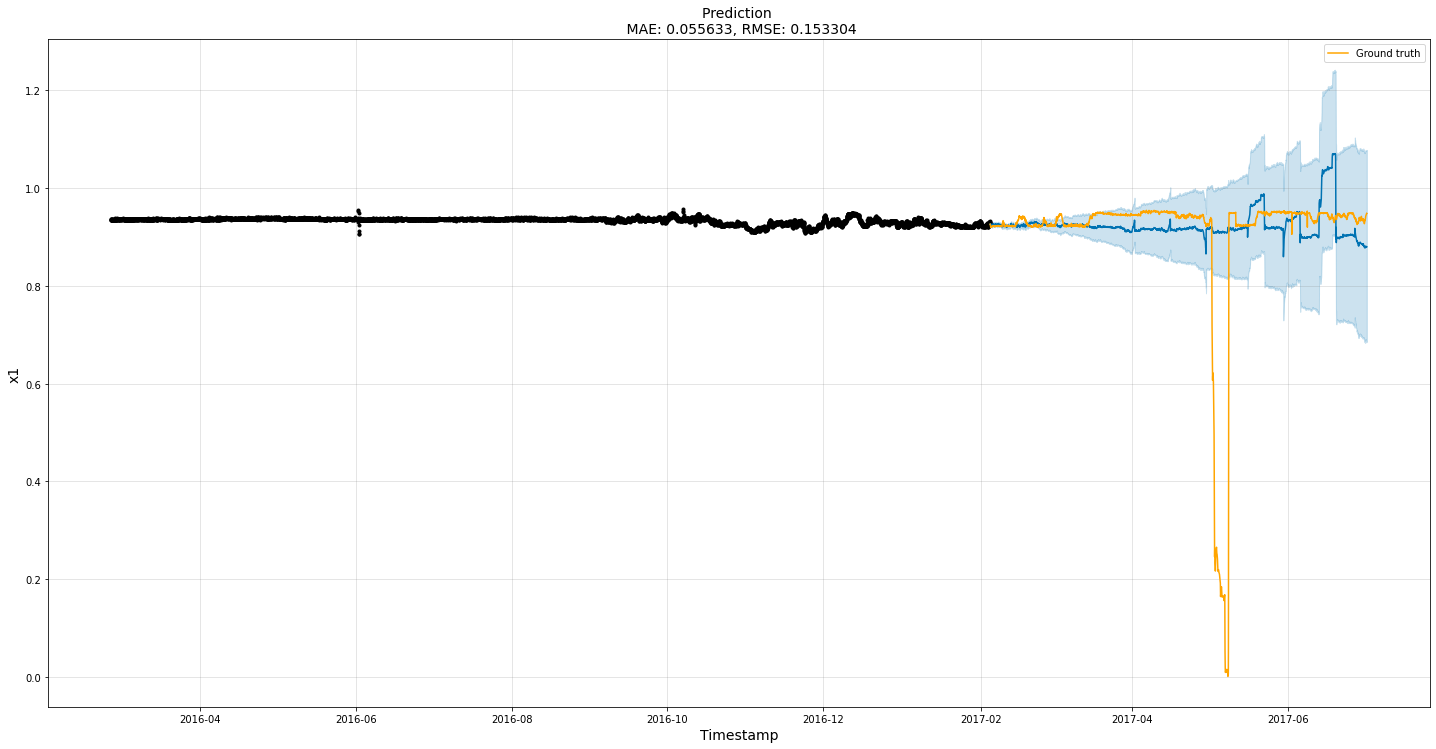

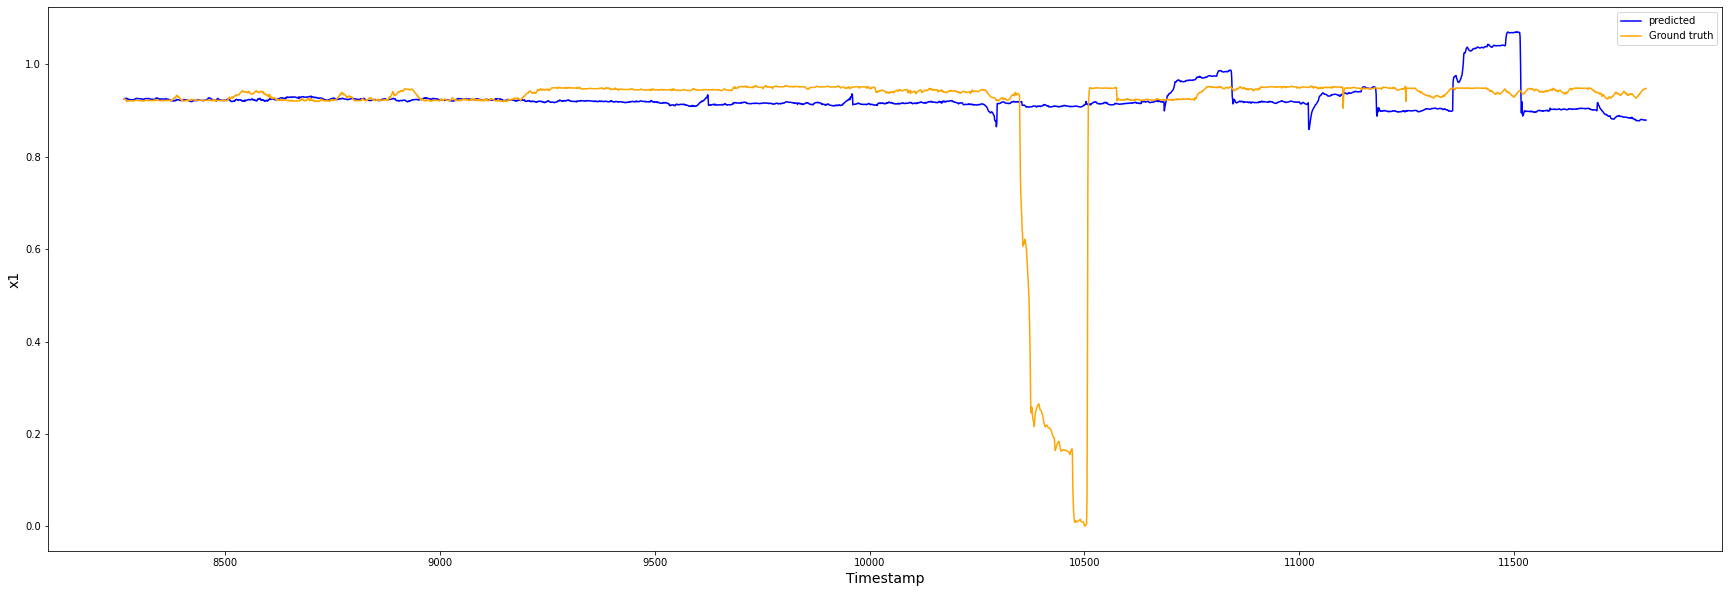

In [ ]:
train_eval(resampled_df, target_column='x1', feature_columns=feature_columns)

Train and validation size
8265 3543


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 0.3749659781344428


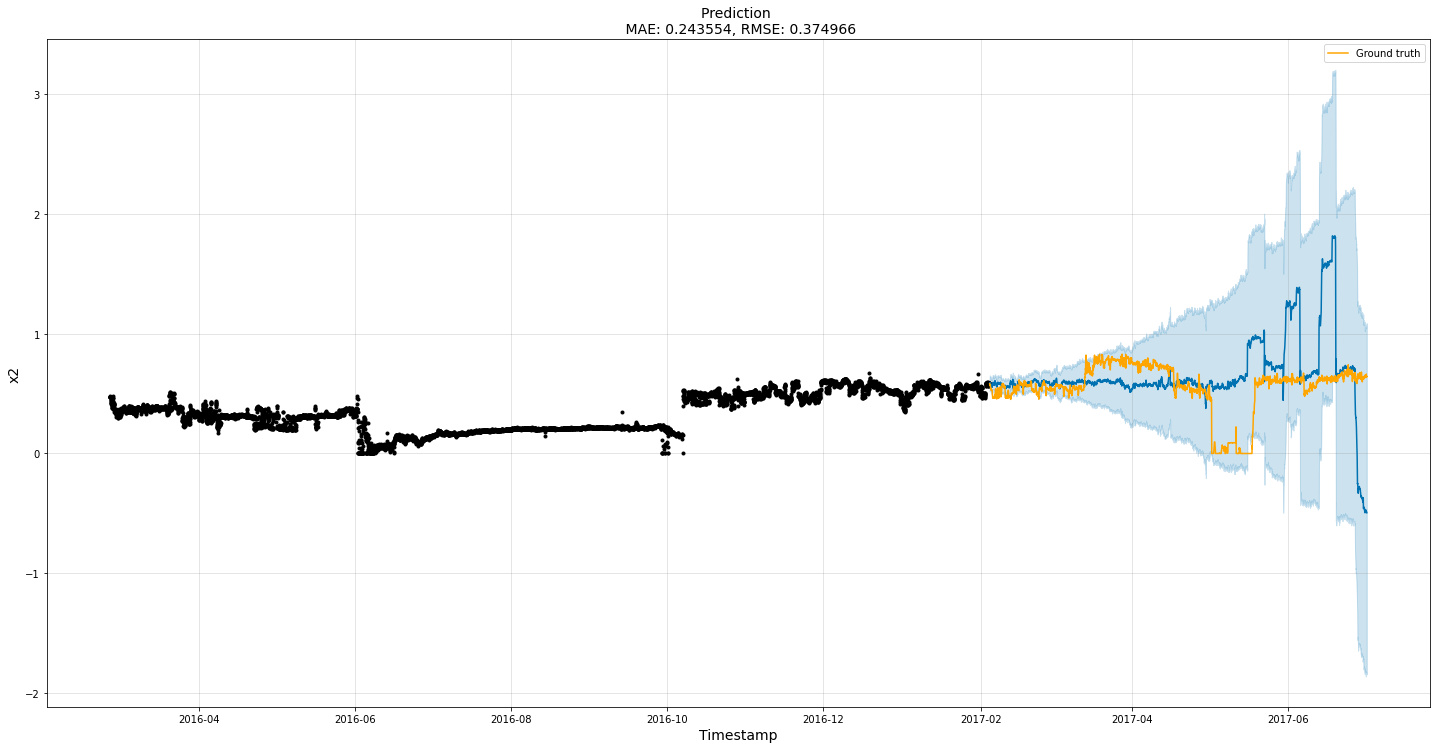

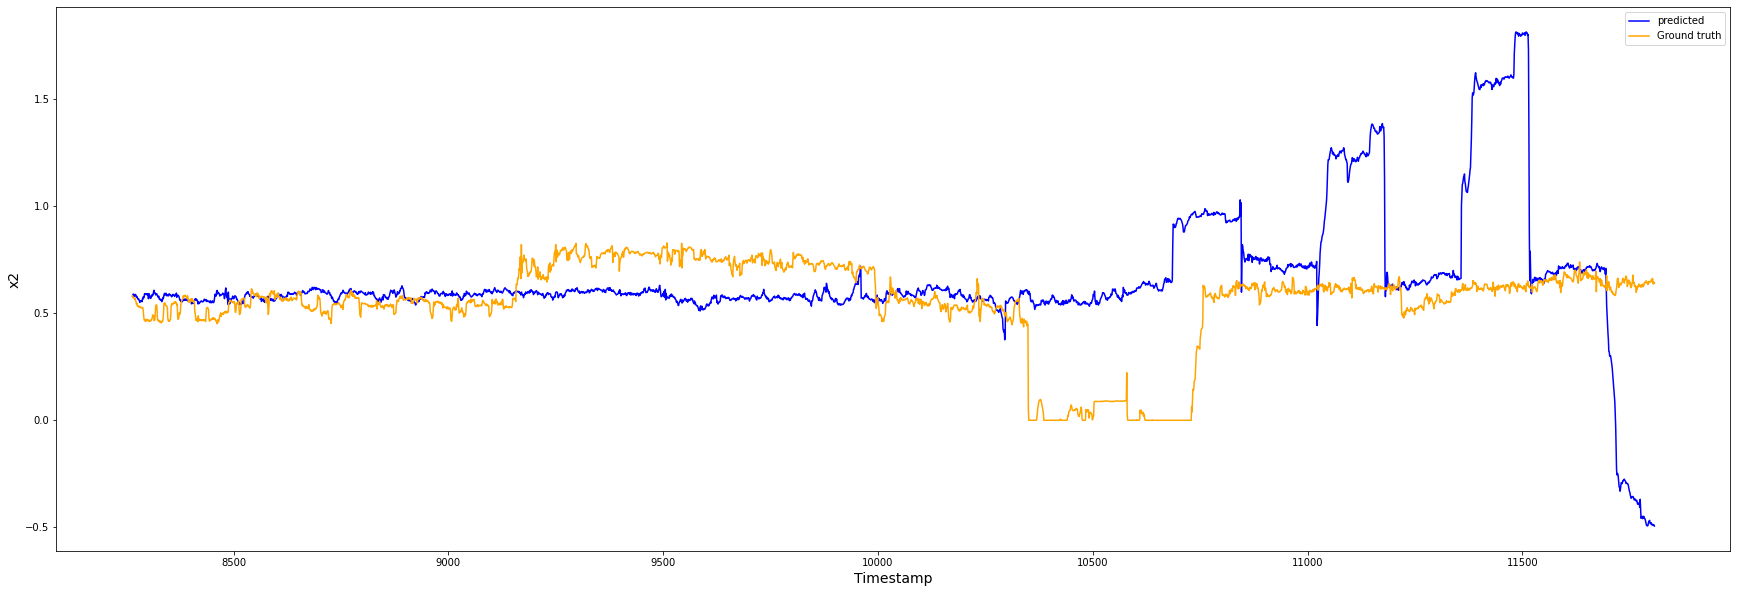

In [ ]:
train_eval(resampled_df, target_column='x2', feature_columns=feature_columns)

Train and validation size
8265 3543


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 0.07421599238773956


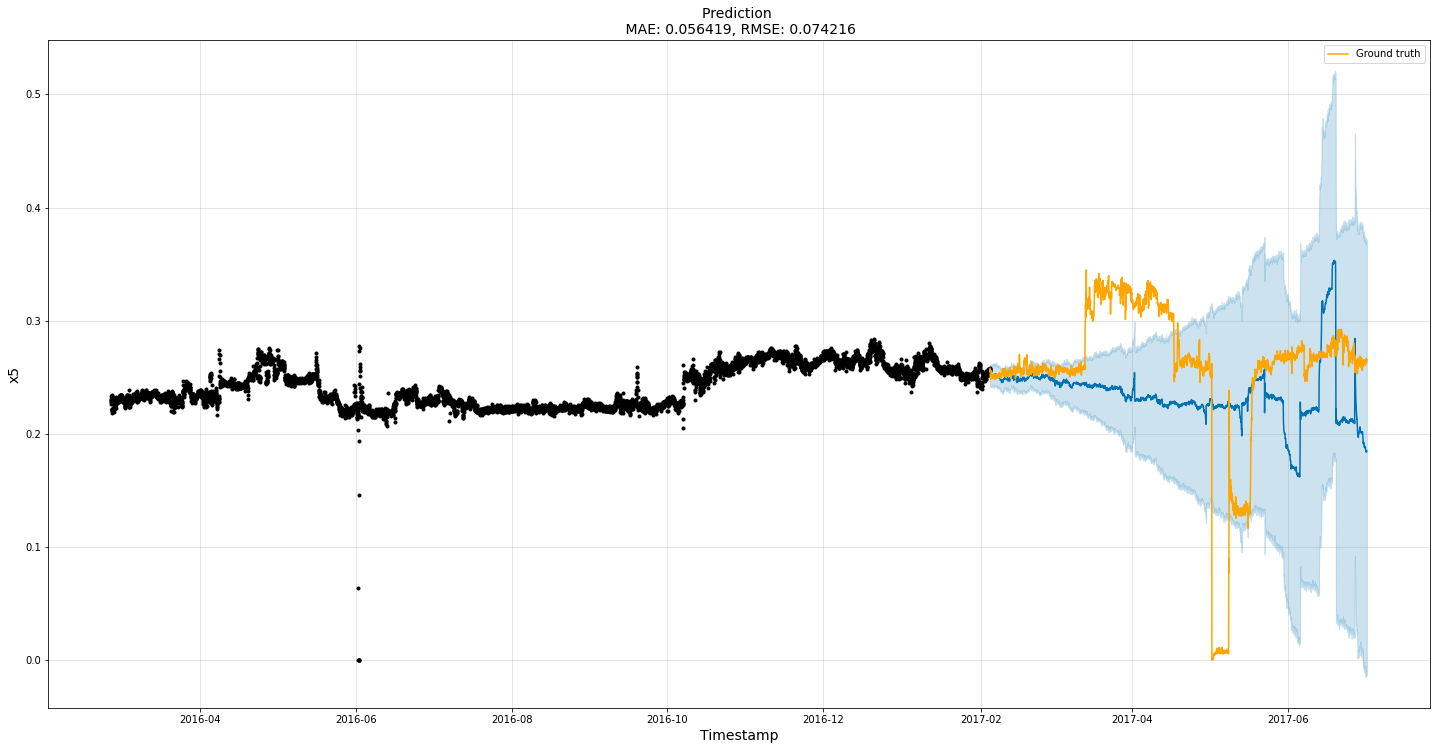

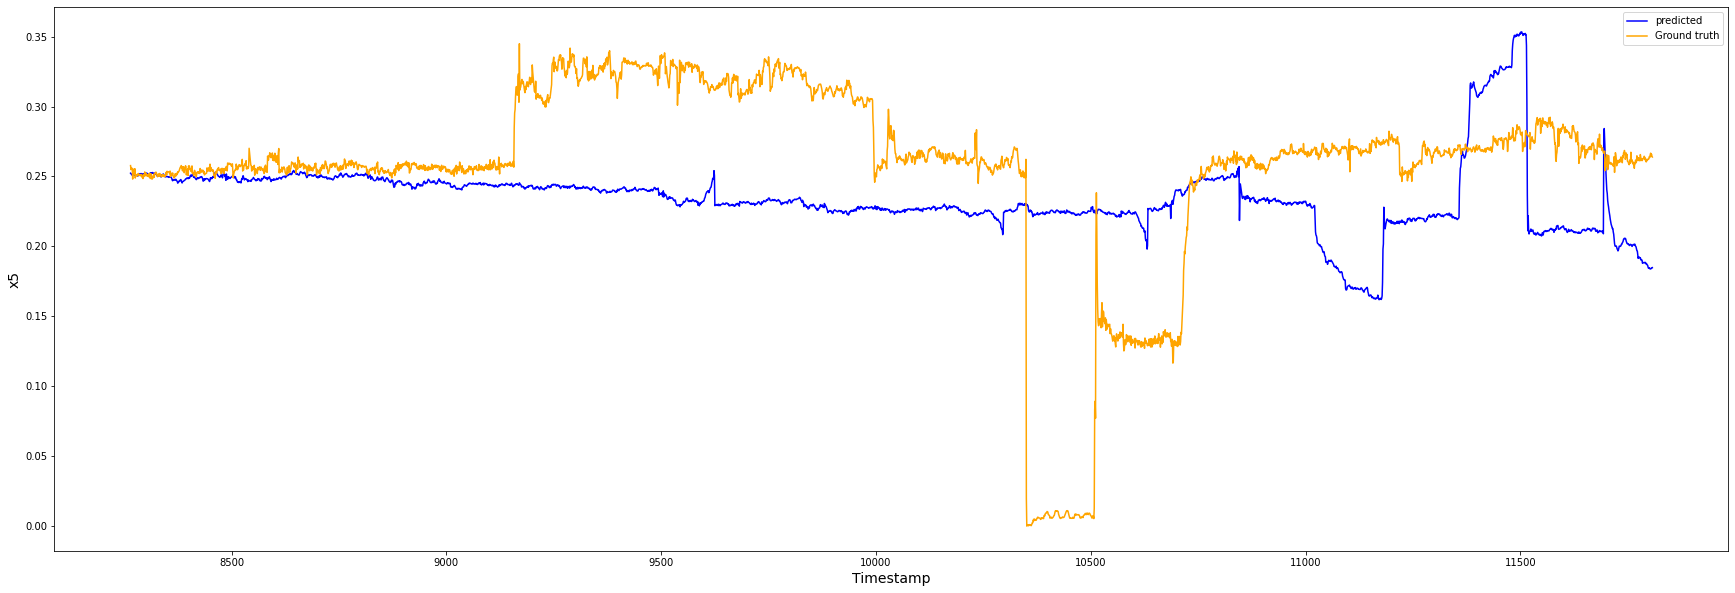

In [ ]:
train_eval(resampled_df, target_column='x5', feature_columns=feature_columns)

<div style="padding:15px;
            background-color:#87b87b">
    - From this, we see that, I would use 5 models to predict x1, x4, x6, x7, x8. The reason I train 5 model separately is to optimize one feature at a time only <br>
    - And later, I would use another model with generated features and use x1, x4, x6, x7 to train x5 (since x4 is strongly correlated to x5) <br>
    - After having generated features and x1, x4-x8, I would use models with these features to train x2, x3 <br>
    - After having all features, I use supervised learning to train y1, y2 <br>

</div>    

Since data is better predicted at the beginning, then I will take partial of data (latest one) to predict future


Train x1, x4, x6, x7, x8 on whole data without sampling

In [ ]:
df_train = df[df.Timestamp > pd.Timestamp(year=2016, month=7, day=1)]
df_train.shape

(105419, 70)

Since model predict good on near future, so in I will take a partial of lastest data near validation 

Train and validation size
73793 31626


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 0.18831639973642977


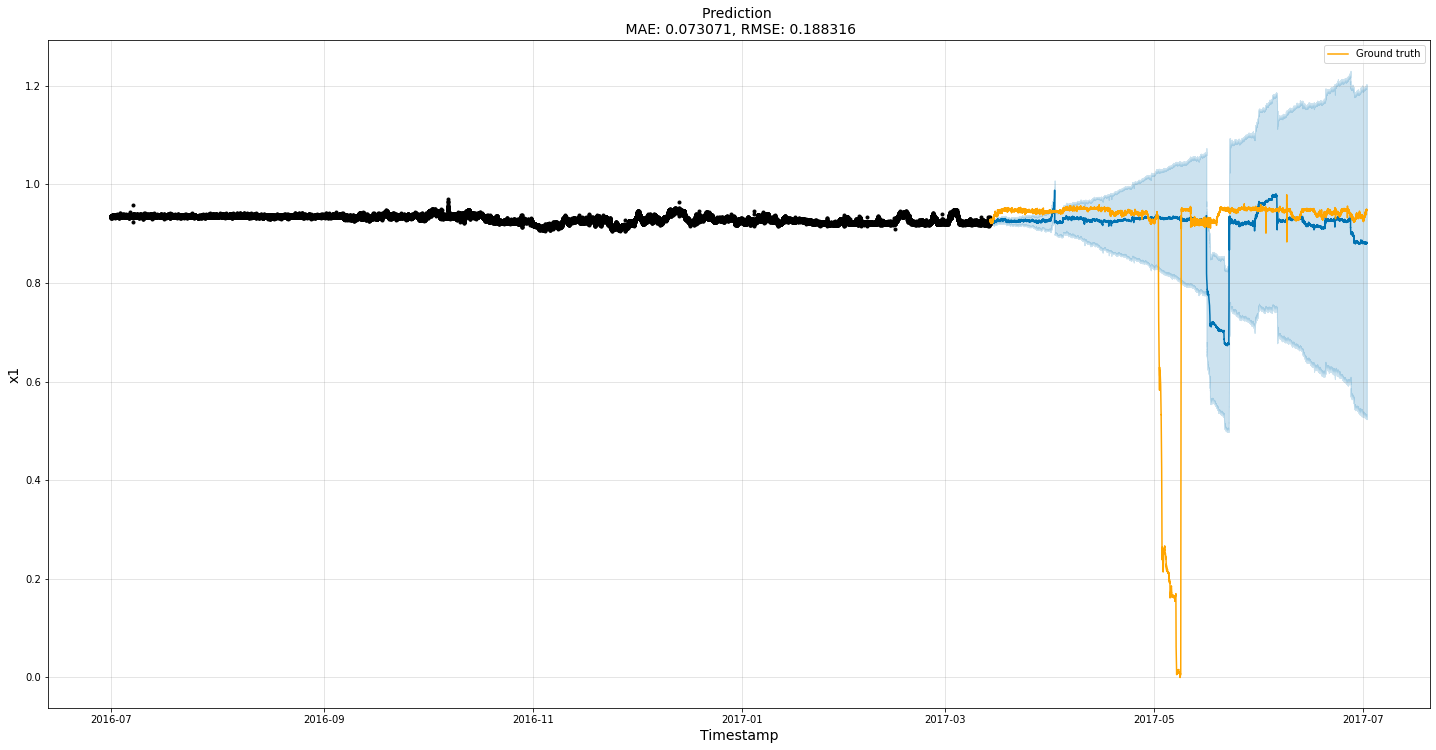

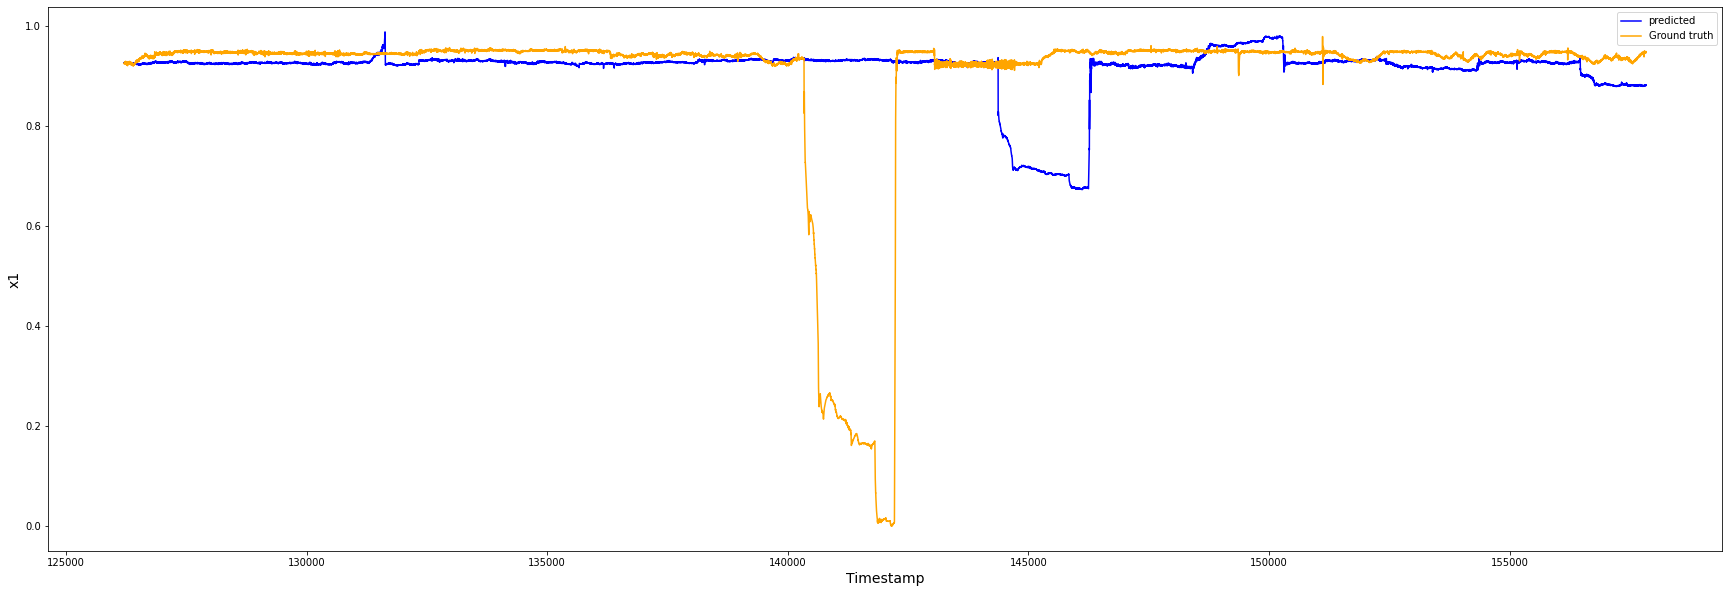

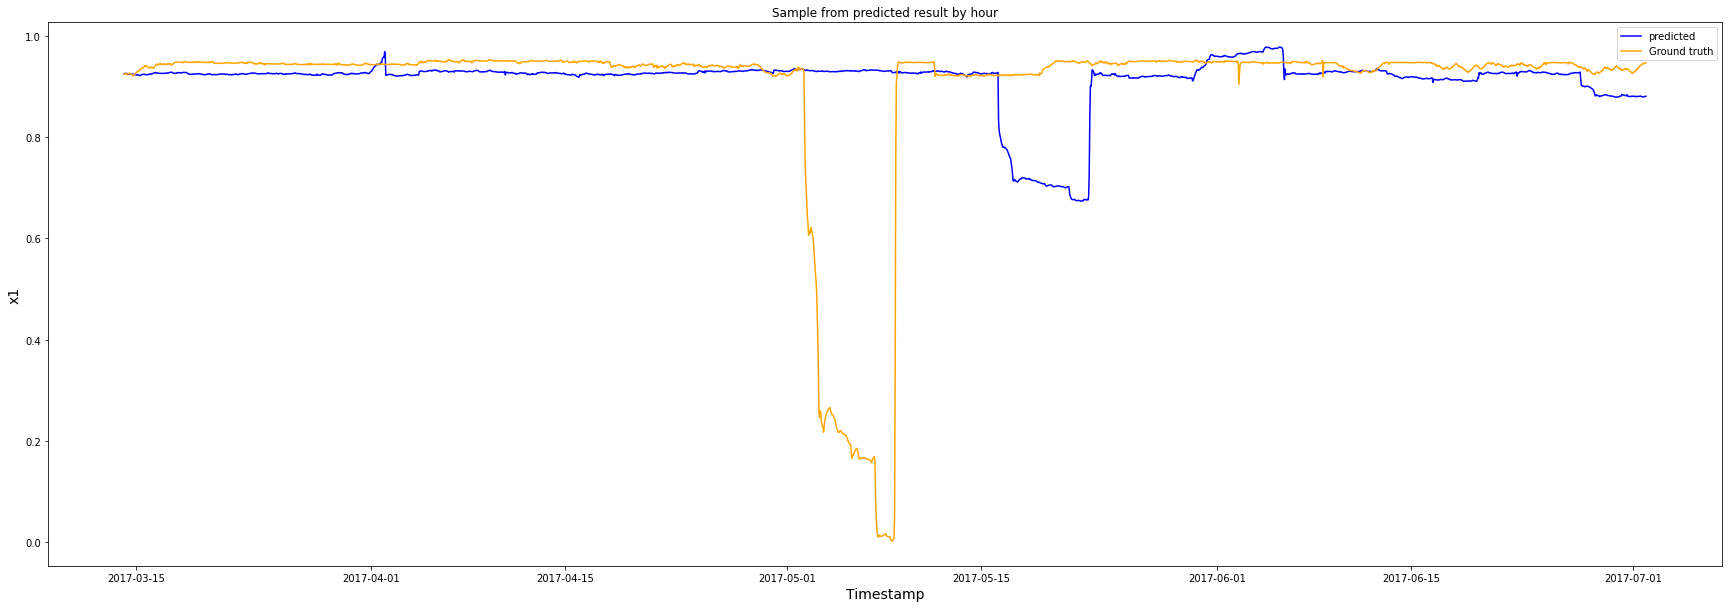

In [ ]:
train_eval(df_train, target_column='x1', feature_columns=feature_columns, sample_result=True)

Train and validation size
73793 31626


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 0.182948444864353


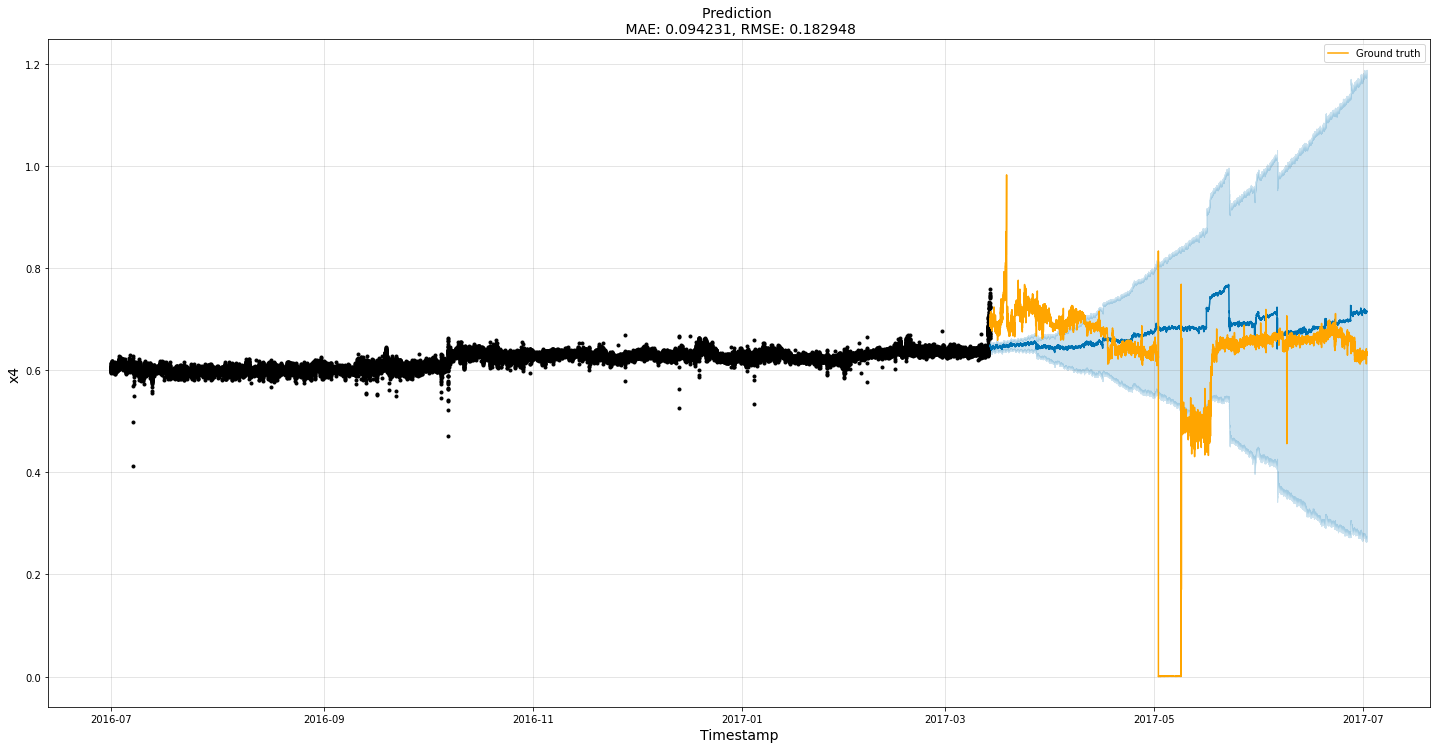

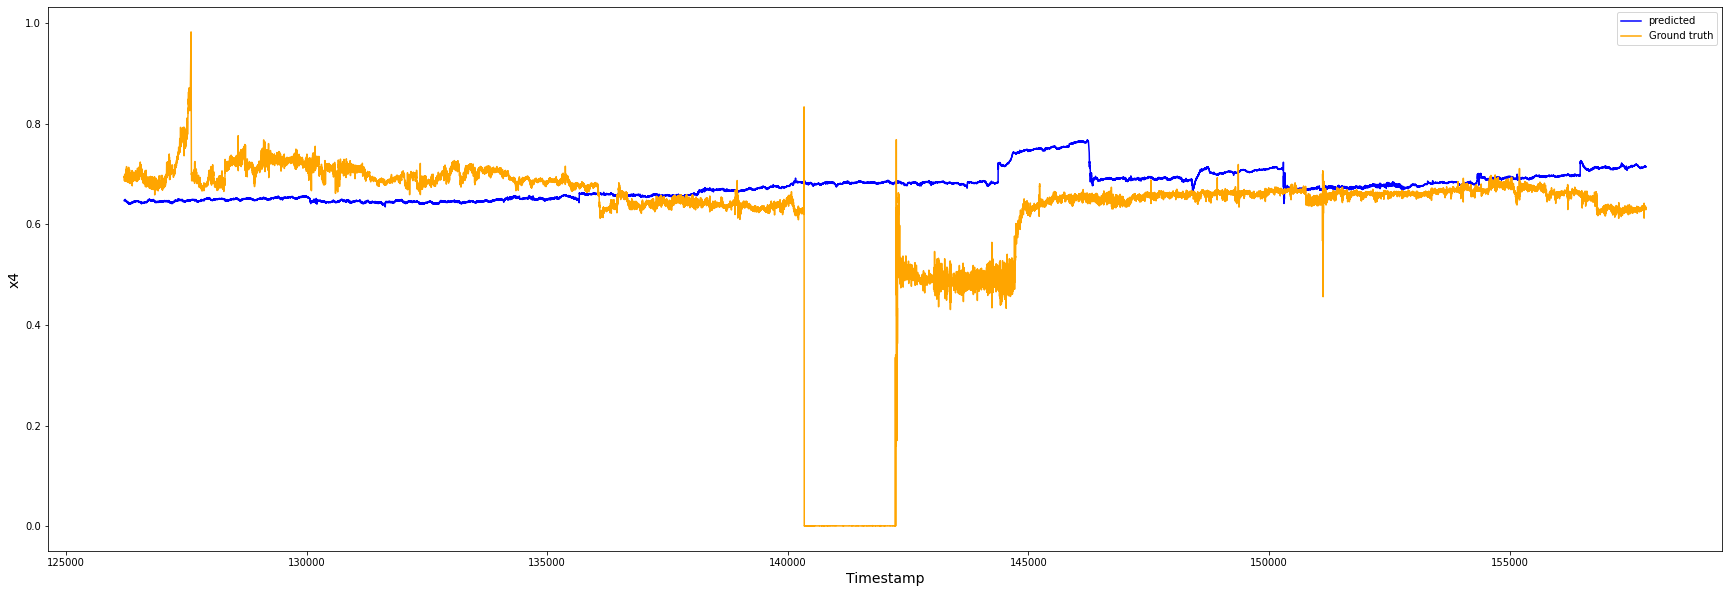

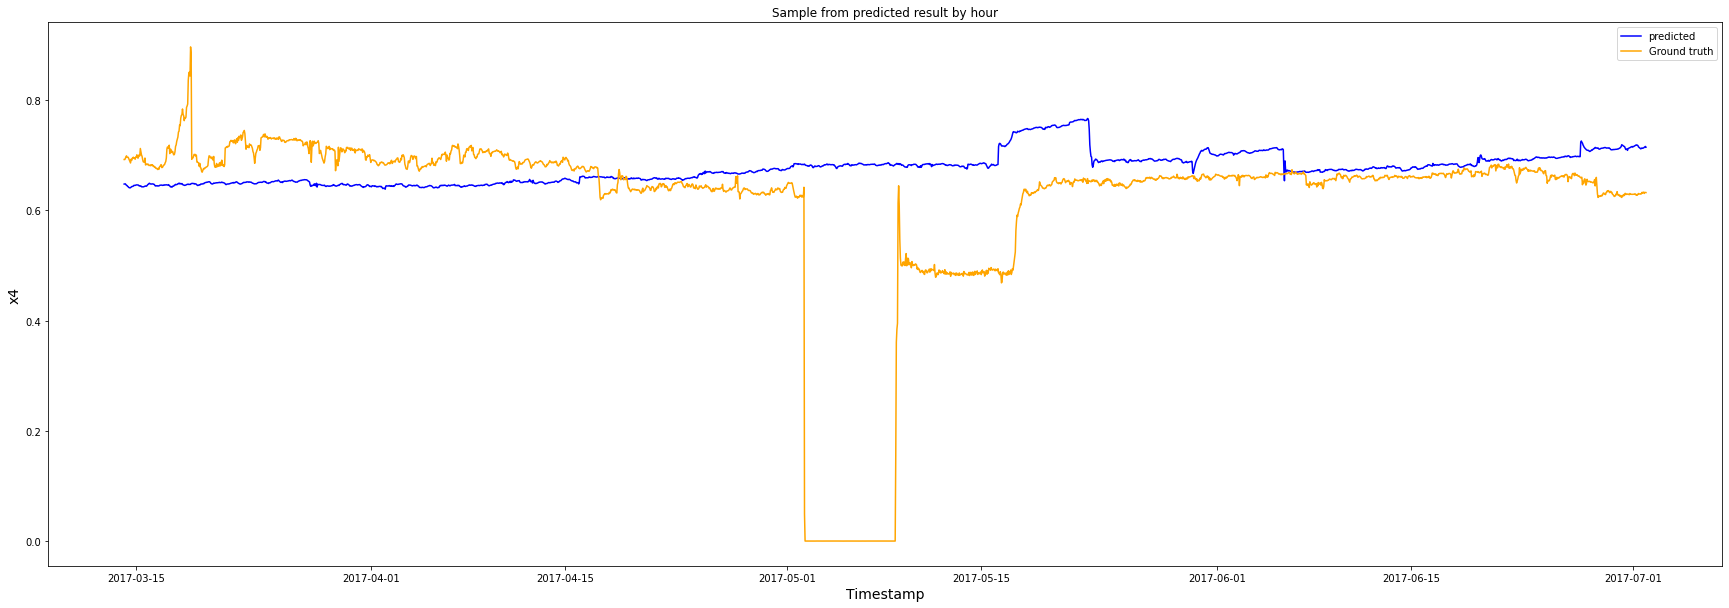

In [ ]:
train_eval(df_train, target_column='x4', feature_columns=feature_columns, sample_result=True)

Train and validation size
73793 31626


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 0.22014349194981586


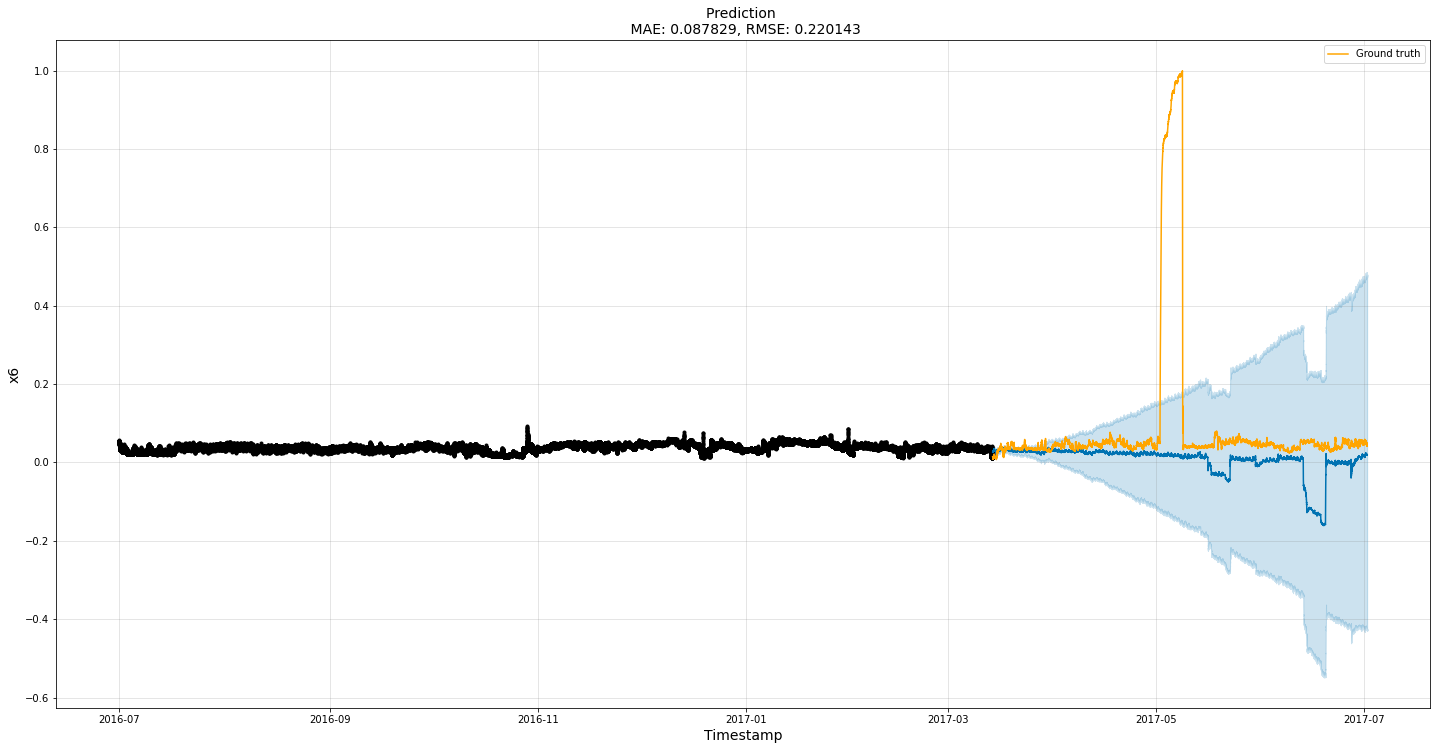

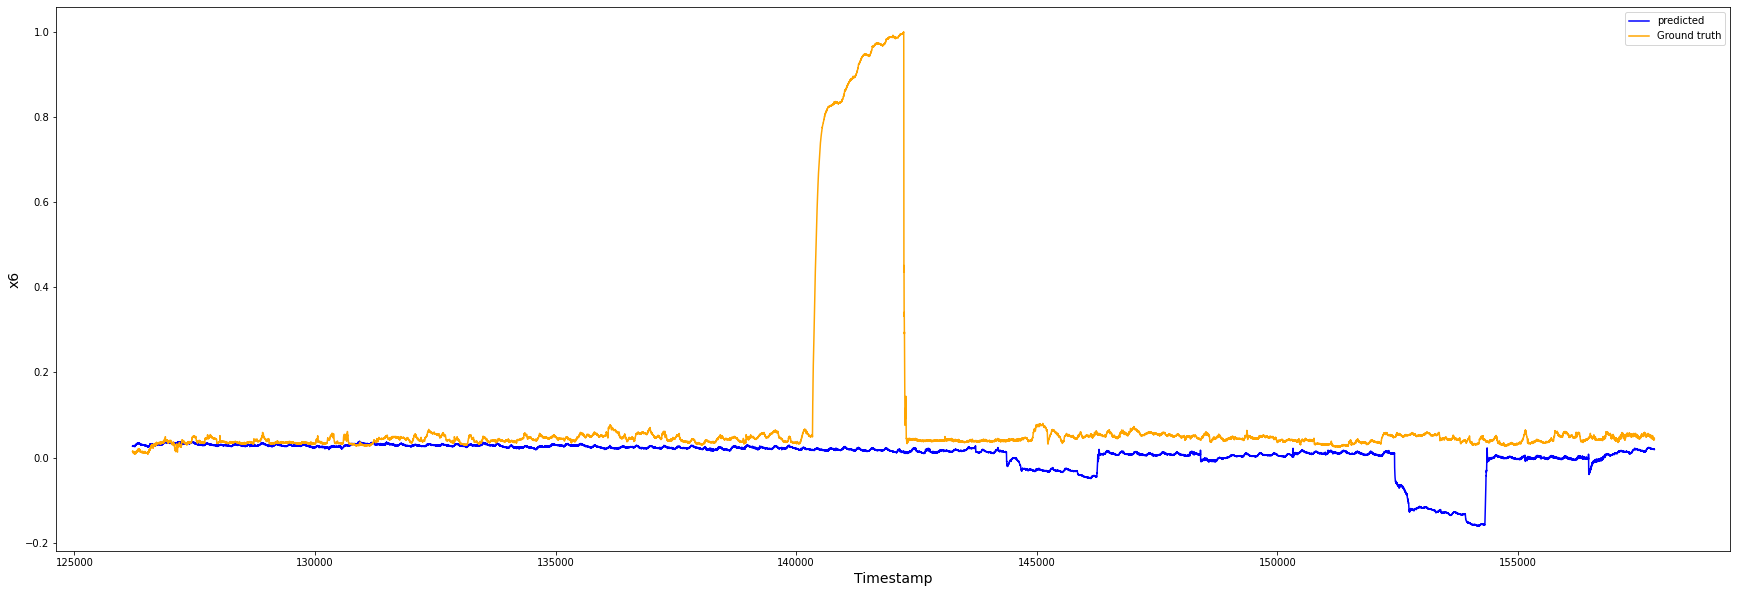

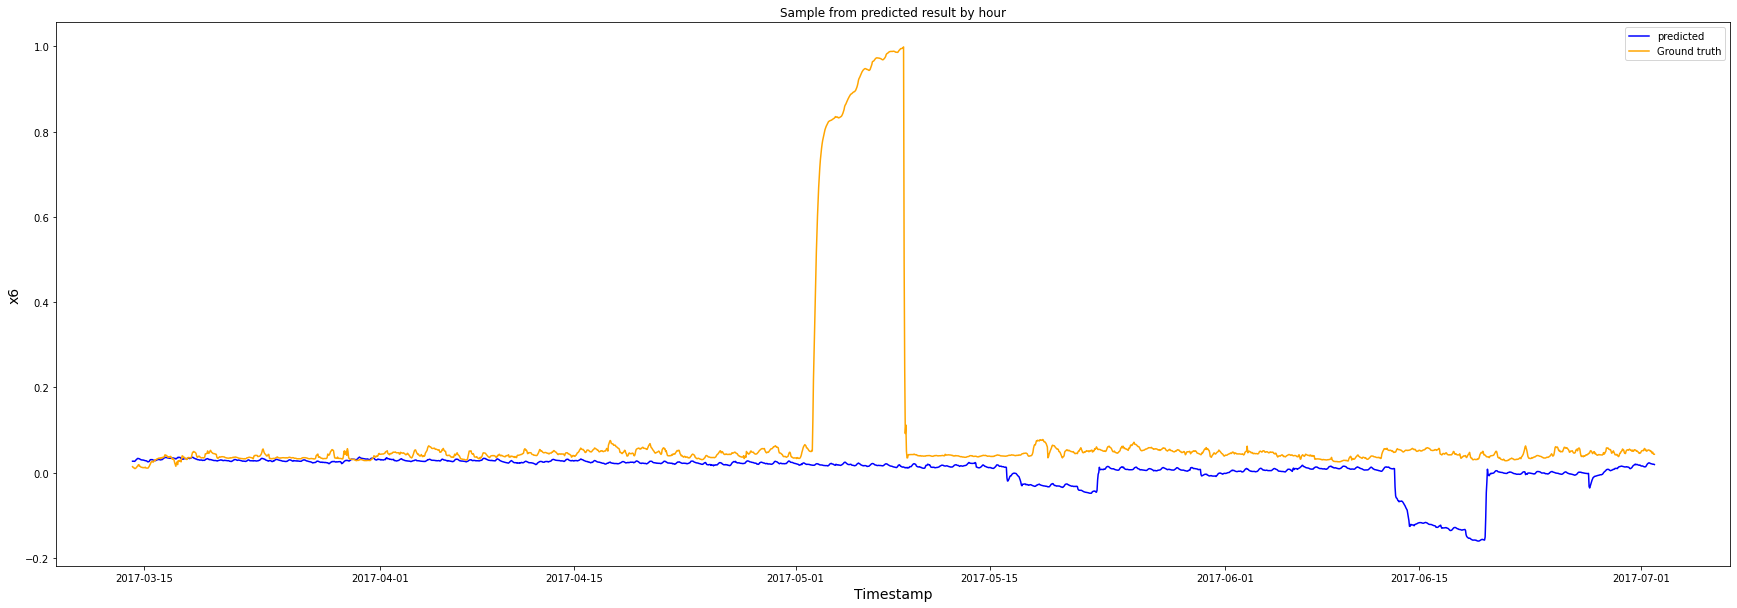

In [ ]:
train_eval(df_train, target_column='x6', feature_columns=feature_columns, sample_result=True)

Train and validation size
73793 31626


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 0.16864857559608964


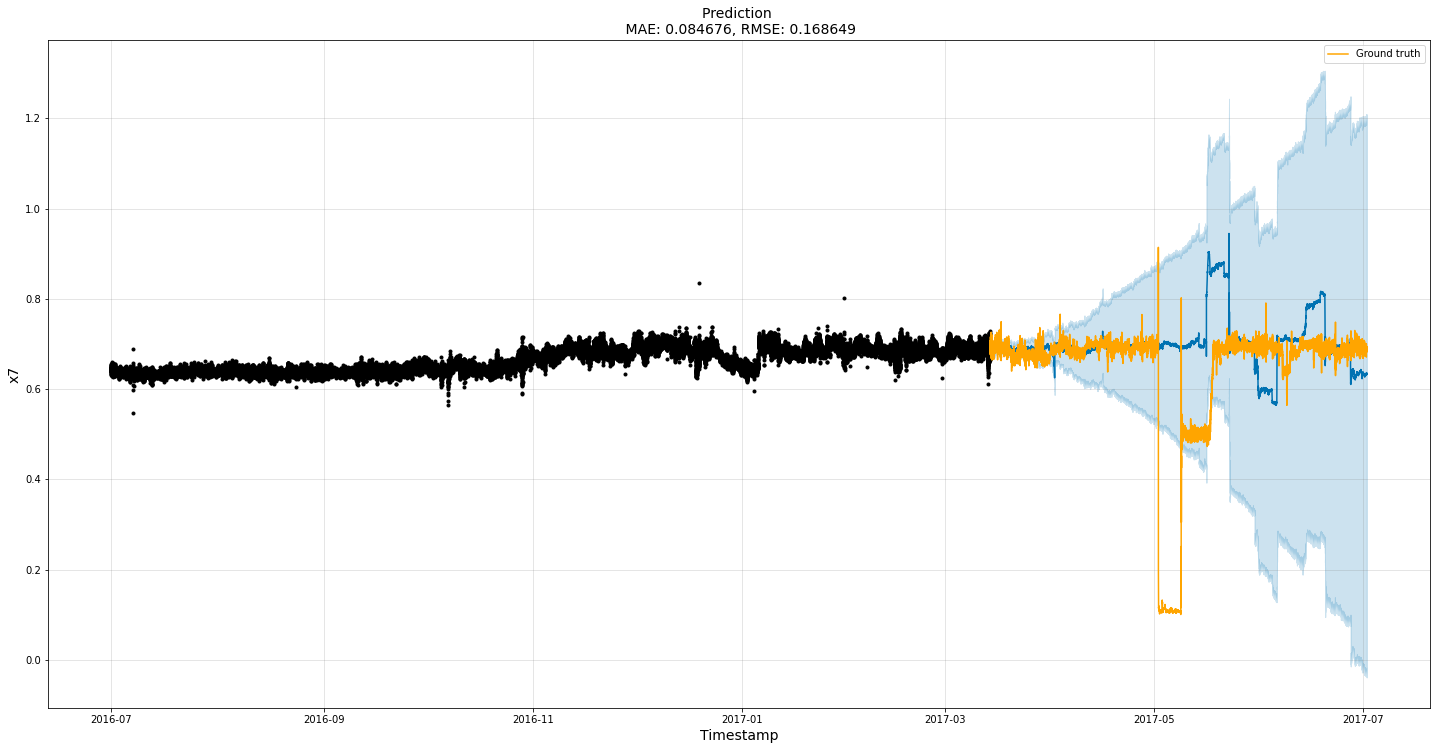

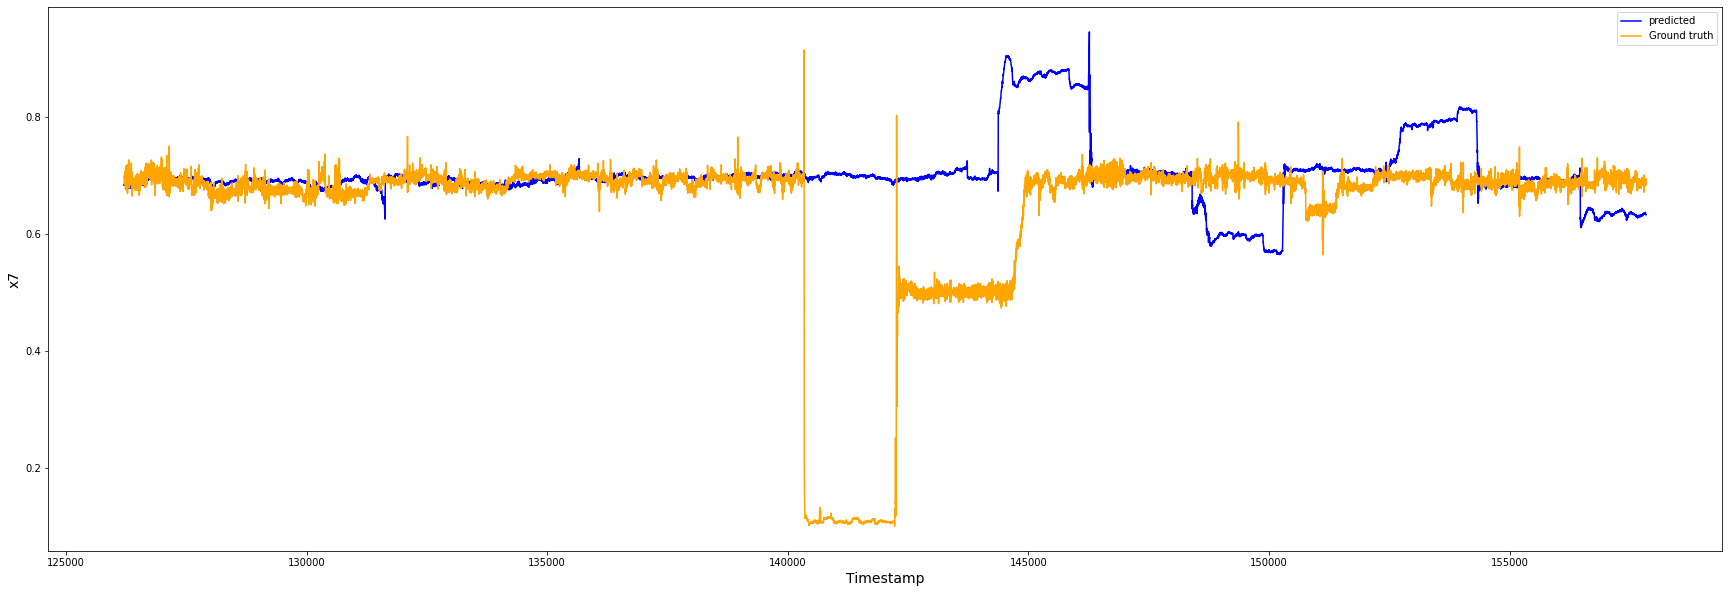

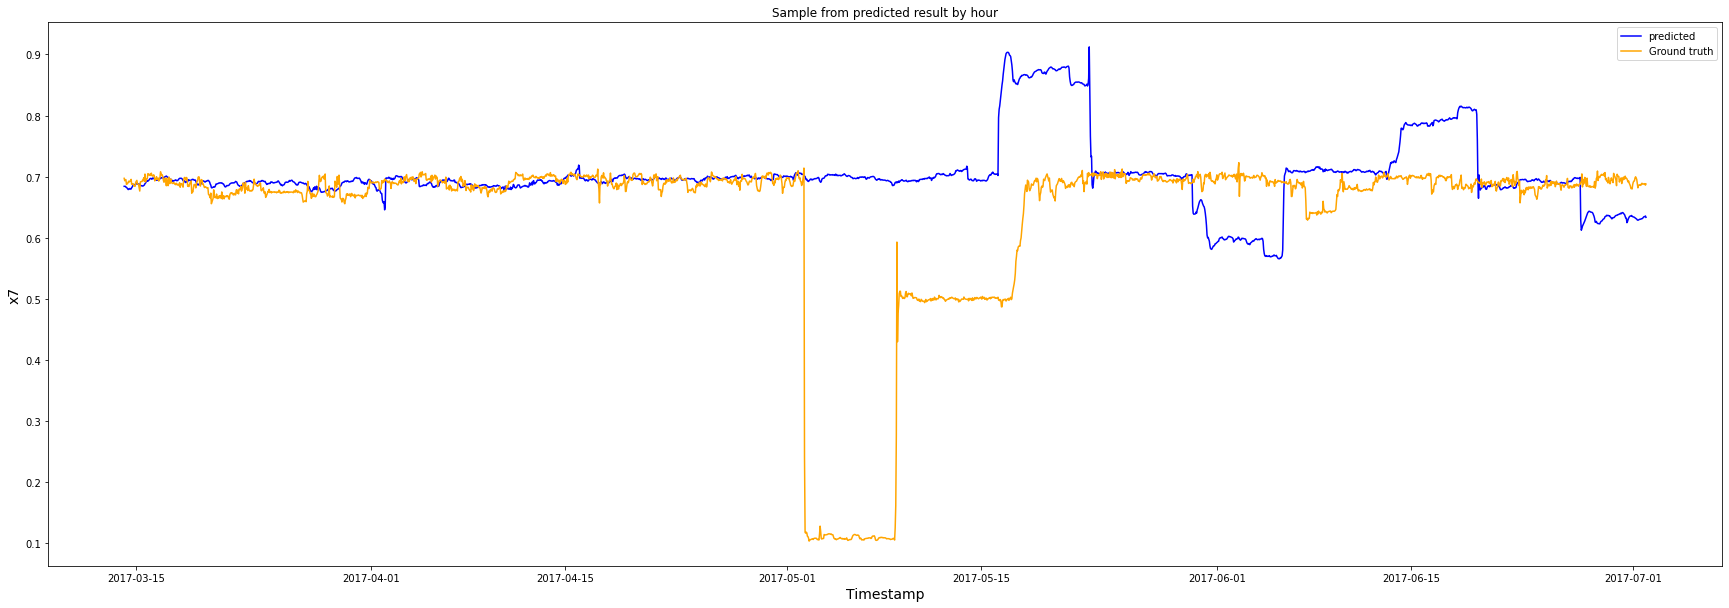

In [ ]:
train_eval(df_train, target_column='x7', feature_columns=feature_columns, sample_result=True)

Train and validation size
99195 42513


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 0.1974848387302714


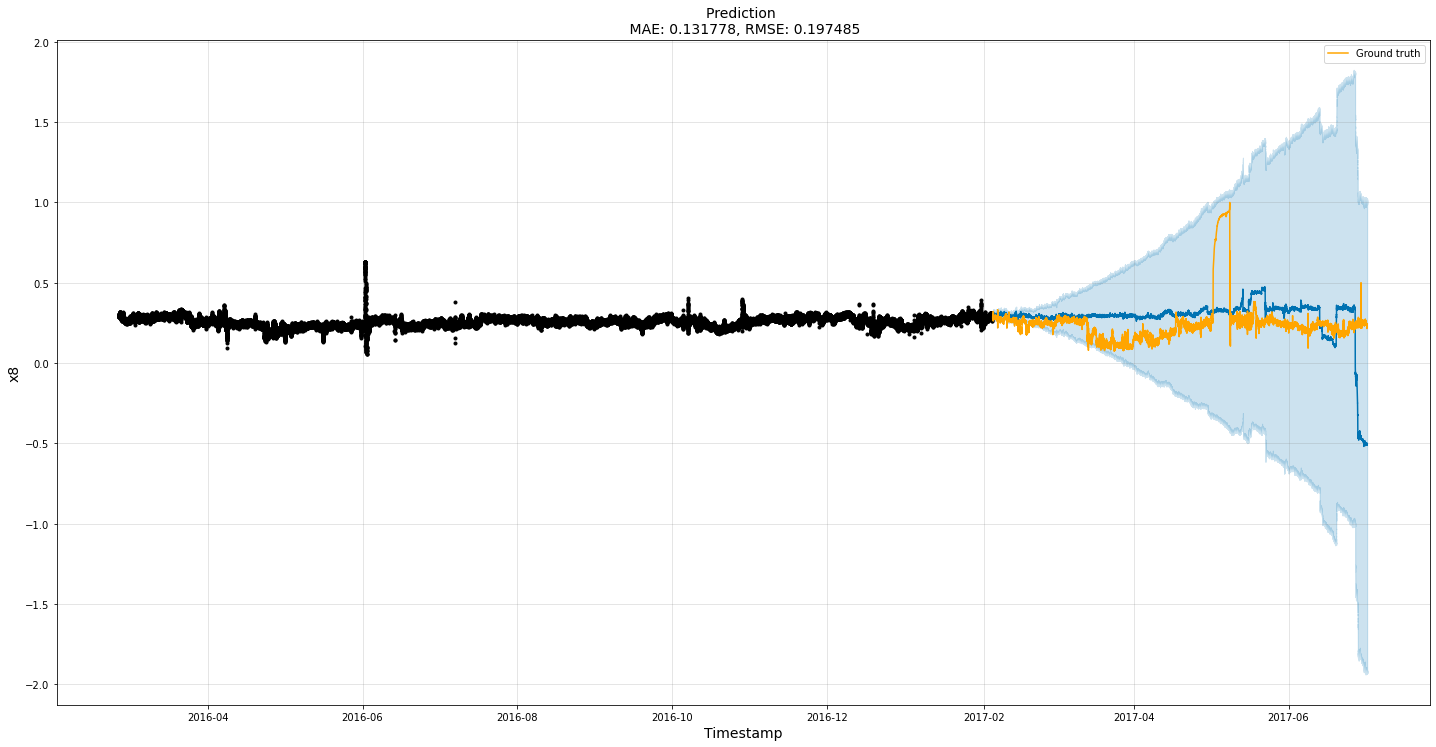

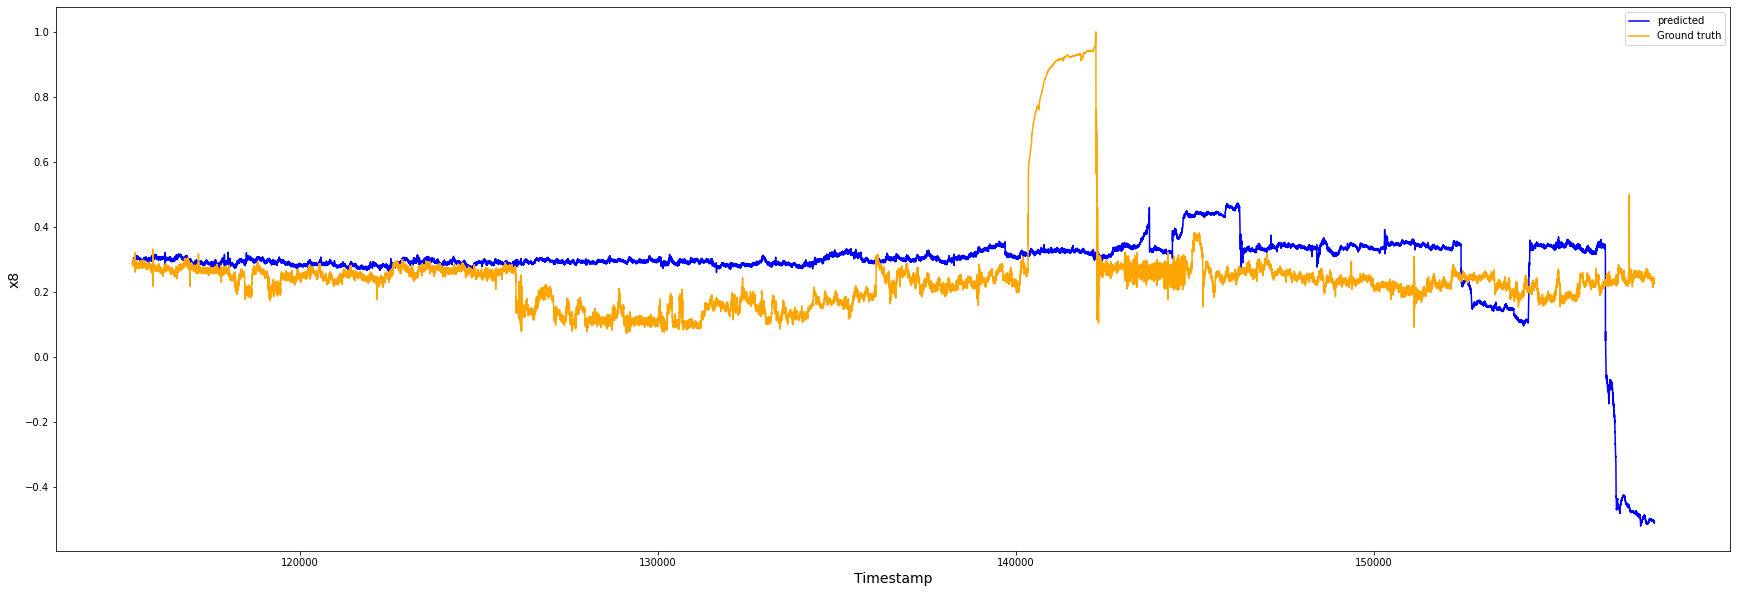

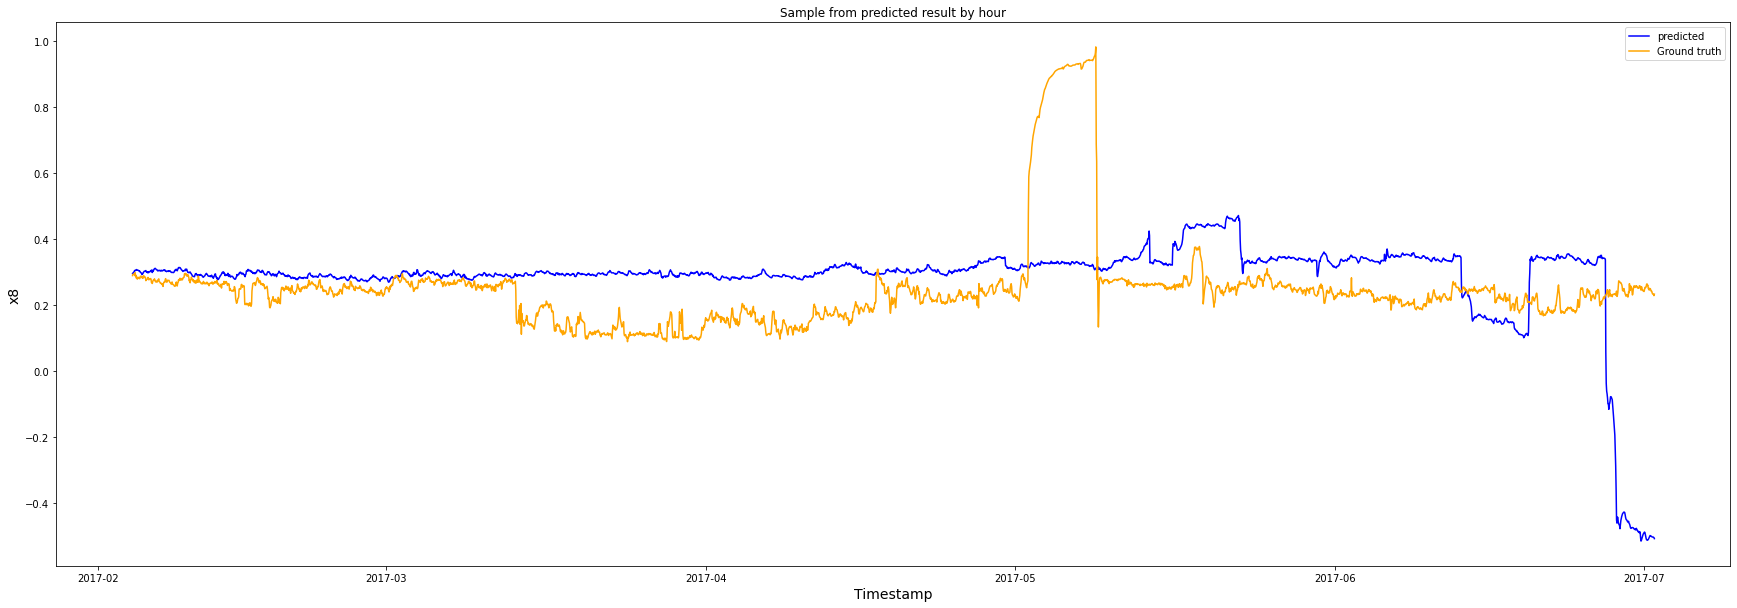

In [ ]:
train_eval(df, target_column='x8', feature_columns=feature_columns, sample_result=True)

Model could predict better at the beginning but cannot predict some time when values increase/descrease suddenly. mae and mse of x7, x8 are quite sigificant, mainly because of outliers. The reason I do not opt out oulier is that Prophet is able to handle the outliers in the history, but only by fitting them with trend changes

Now, in order to train model for predicting next 14 days, I would take 6-month back from 2017-07-01

In [ ]:
def train(df, target_column, feature_columns):

  multivariate_df = df[['Timestamp'] + [target_column] + feature_columns].copy()
  multivariate_df.columns = ['ds', 'y'] + feature_columns

  train = multivariate_df.copy()
  x_train, y_train = pd.DataFrame(multivariate_df.iloc[:, [0]+ [*range(2,multivariate_df.shape[1])]]), pd.DataFrame(multivariate_df.iloc[:, 1])

  print('Train size')
  print(len(y_train))

  


# Train the model
  model = Prophet()
  for col in feature_columns:
    model.add_regressor(col)

  # Fit the model with train set
  model.fit(train.fillna(0))
  import pickle
  pkl_path = f"model_{target_column}.pkl"
  with open(pkl_path, "wb") as f:
      # Pickle the 'Prophet' model using the highest protocol available.
      pickle.dump(model, f)


In [ ]:
df_train = df[df.Timestamp > pd.Timestamp(year=2017, month=1, day=1)]
df_train.shape

(52415, 70)

In [ ]:
train(df_train, target_column='x1', feature_columns=feature_columns)

Train size
52415


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [20]:
train(df_train, target_column='x4', feature_columns=feature_columns)

Train size
52415


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [21]:
train(df_train, target_column='x6', feature_columns=feature_columns)

Train size
52415


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [22]:
train(df_train, target_column='x7', feature_columns=feature_columns)

Train size
52415


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [23]:
train(df_train, target_column='x8', feature_columns=feature_columns)

Train size
52415


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
